<a href="https://colab.research.google.com/github/batatovich/projects/blob/main/Metapoblacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as random
import torch as T
import torch.nn.functional as F
import cv2 
import networkx as nx
from tqdm import tqdm

In [26]:
class network():
    def __init__(self, N, device, topology = 'lattice', m = 4):
        self.N0 = N
        self.device = device
        self.topology = topology
        if topology == 'barabassi':
          self.barabassi(m)
        else:
          self.lattice()

    def lattice(self):
        N_ = int(np.sqrt(self.N0)) #If N is not a perfect square
        G = nx.grid_graph([N_, N_])
        self.N = N_**2 #New N
        mapping = dict(zip(G, range(self.N)))
        G = nx.relabel_nodes(G, mapping) #Renames all nodes, so they are all consecutive intergers.
        self.G = G

    def barabassi(self, m):
        self.m = m
        self.G = nx.barabasi_albert_graph(self.N0, m)

    def remove_nodes(self, D = 0, Nd = 0, random_removal = True):
        self.D = D
        self.Nd = Nd
        self.random_removal = random_removal
        if random_removal: #Wheter we want to remove random nodes or specific ones.
            if D != 0:
                removed_nodes = random.sample(range(self.N0), int(D*self.N0))
                self.G.remove_nodes_from(removed_nodes)
                self.N = self.G.number_of_nodes()
                mapping = dict(zip(self.G, range(self.N)))
                self.G = nx.relabel_nodes(self.G, mapping) 
        else:
            if Nd != 0:
                nodes = [n for n in self.G.nodes()]
                degrees = [self.G.degree(nodes[n]) for n in nodes]
                ordered_nodes = np.flip([x for _,x in sorted(zip(degrees,nodes))]) #Ordered by degree, from max to min.
                removed_nodes = ordered_nodes[0:Nd]
                self.G.remove_nodes_from(removed_nodes)
                self.N = self.G.number_of_nodes()
                mapping = dict(zip(self.G, range(self.N)))
                self.G = nx.relabel_nodes(self.G, mapping)   
        if D == 0 and Nd == 0:
          self.N = self.G.number_of_nodes()    

    def disable_nodes(self, D = 0, Nd = 0, random_removal = True):
      #Disable nodes without removing them from the network.
      pass

    def adjacency_matrix(self):
        self.matrix_type = 'adjacency'
        self.A = nx.to_numpy_matrix(self.G)

    def sparse_matrix(self):
        self.matrix_type = 'sparse'
        self.A = T.tensor(nx.to_numpy_matrix(self.G), dtype = T.float32, device = self.device).to_sparse()

    def sparse_coo_matrix(self):
        #This method avoids creation of numpy array. It allows bigger networks but operations are slower.
        self.matrix_type = 'sparse_coo'
        i = []
        for n in self.G.nodes():
            for neig in self.G.neighbors(n):
                i.append([n, neig])
        v = np.ones(len(i))
        i = np.array(i).T
        self.A = T.sparse_coo_tensor(i, v, (self.N, self.N), dtype = T.float32, device = self.device)

    def initial_occupancy(self, x10, x20, y0):
        self.x10 = x10
        self.x20 = x20
        self.y0 = y0
        #x10, x20, y0 are the occupancy fractions for each species.
        x1_ids = random.sample(range(self.N), int(self.N*x10))
        x2_ids = random.sample(range(self.N), int(self.N*x20))
        y_ids  = random.sample(range(self.N), int(self.N*y0))

        x1 = [0]*self.N
        x2 = [0]*self.N
        y  = [0]*self.N

        for id in x1_ids:
            x1[id] = 1
        for id in x2_ids:
            x2[id] = 1
        for id in y_ids:
            y[id] = 1

        self.x1 = T.tensor(x1, dtype = T.float32, device = self.device) 
        self.x2 = T.tensor(x2, dtype = T.float32, device = self.device)
        self.y  = T.tensor(y , dtype = T.float32, device = self.device)
        
        return self.x1, self.x2, self.y

    def reset_dynamics(self):
      self.initial_occupancy(self.x10, self.x20, self.y0)

    def reset(self):
      if self.topology == 'barabassi':
        self.barabassi(self.m)
      else:
        self.lattice()
      self.remove_nodes(self.D, self.Nd, self.random_removal)
      self.initial_occupancy(self.x10, self.x20, self.y0)
      if self.matrix_type == 'sparse':
        self.sparse_matrix()
      if self.matrix_type == 'sparse_coo':
        self.sparse_coo_matrix()
      if self.matrix_type == 'adjacency':
        self.adjacency_matrix()

    def set_species_params(self, params):
      self.cx1 = params[0]
      self.cx2 = params[1]
      self.ex1 = params[2]
      self.ex2 = params[3]
      self.mux1 =params[4]
      self.mux2 =params[5]
      self.cy =  params[6]
      self.ey =  params[7]

    def update(self):
      x1_ = self.x1.clone()
      x2_ = self.x2.clone()
      y_  =  self.y.clone()   
      
      #Number of neighbors for each node
      n_x1 = T.sparse.mm(self.A, self.x1.view(-1,1)).view(1,-1)
      n_x2 = T.sparse.mm(self.A, self.x2.view(-1,1)).view(1,-1)
      n_y  = T.sparse.mm(self.A, self.y.view(-1,1) ).view(1,-1)

      #Colonization
      m1 = (self.x1 == 0) #x2 and y allowed
      m2 = (self.x1 == 0)*(self.x2 == 0) #y allowed
      my = ((self.x1 == 1) + (self.x2 == 1))*(y == 0) #Only preys

      x1_ = x1_ + m1*(T.rand(self.N, device = self.device) < (1 - T.pow(1-self.cx1, n_x1)))*1
      x2_ = x2_ + m2*(T.rand(self.N, device = self.device) < (1 - T.pow(1-self.cx2, n_x2)))*1
      y_  = y_  + my*(T.rand(self.N, device = self.device) < (1 - T.pow(1-self.cy ,  n_y)))*1

      #Predation
      x1_ = x1_ - (self.x1 == 1)*(self.y == 1)*(T.rand(self.N, device = self.device) < self.mux1)*1
      x2_ = x2_ - (self.x2 == 1)*(self.y == 1)*(T.rand(self.N, device = self.device) < self.mux2)*1

      #Extinction
      x1_ = T.relu(x1_ - (T.rand(self.N, device = self.device) < self.ex1)*(self.x1 == 1)*1)
      x2_ = T.relu(x2_ - (T.rand(self.N, device = self.device) < self.ex2)*(self.x2 == 1)*1)
      y_  = T.relu(y_  - (T.rand(self.N, device = self.device) < self.ey)*(self.y   == 1)*1)
      
      #Competitive displacement 
      x2_ = T.relu(x2_ - (self.x1 == 1)*(self.x2 == 1)*(T.rand(self.N, device = self.device) < self.cx1)*1)
      
      #Update
      self.x1 = x1_
      self.x2 = x2_
      self.y  = y_
      return self.x1, self.x2, self.y

100%|██████████| 1000/1000 [00:04<00:00, 224.81it/s]


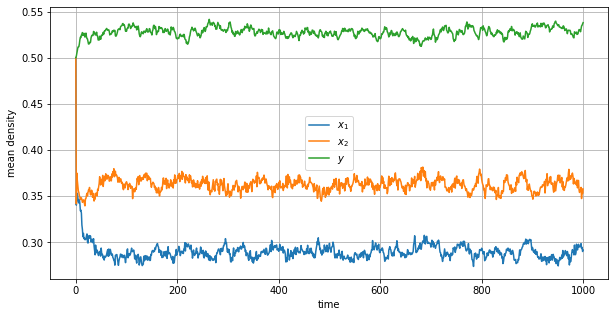

In [113]:
#Current device
device = T.device("cuda" if T.cuda.is_available() else "cpu")

#Global parameters
N = 10000 #If N too large (> 10000), use sparse_coo. Otw use sparse, as its much faster.
m = 4 #Barabasi-albert parameter
max_it = 1000 #Number of iterations in the simulation
sparce_coo = False

#Model parameters
cx1 = .05
cx2 = .1
ex1 = .05
ex2 = .01
mux1 = .9
mux2 = .9
cy = .015
ey = .04
params = np.array([cx1, cx2, ex1, ex2, mux1, mux2, cy, ey])

#Forbidden nodes
random_desconection = True
D = .0 #If random selection desired
Nd = int(D*N) #First Nd nodes (of max degree) to be deleted

world = network(N, device, 'barabassi', m)
world.remove_nodes(D = D, Nd = Nd, random_removal = random_desconection)
N = world.N
x1, x2, y = world.initial_occupancy(.5,.5,.5)
world.set_species_params(params)

if sparce_coo:
    #List of neigbhors -> sparce_coo tensor.
    world.sparse_coo_matrix()
else:
    #G -> numpy array of adjacency matrix -> sparse tensor of A.
    world.sparse_matrix()
###
x1_t = T.sum(x1).view(1,-1)/N
x2_t = T.sum(x2).view(1,-1)/N
y_t  = T.sum(y).view(1,-1)/N
for _ in tqdm(range(max_it)):
    x1, x2, y = world.update()
    x1_t = T.cat((x1_t, T.sum(x1).view(1,-1)/N))
    x2_t = T.cat((x2_t, T.sum(x2).view(1,-1)/N))
    y_t  = T.cat((y_t,  T.sum(y ).view(1,-1)/N))
world.reset()
x1_t = x1_t.detach().cpu().numpy()
x2_t = x2_t.detach().cpu().numpy()
y_t  = y_t.detach().cpu().numpy()
fig = plt.figure(figsize=(10,5))
plt.plot(x1_t, label = r'$x_{1}$')
plt.plot(x2_t, label = r'$x_{2}$')
plt.plot(y_t, label = r'$y$')
plt.xlabel('time')
plt.ylabel('mean density')
plt.grid()
plt.legend(loc = 'best')
plt.show()

In [ ]:
#Current device
device = T.device("cuda" if T.cuda.is_available() else "cpu")

#Global parameters
N = 10000 #If N too large (> 10000), use sparse_coo. Otw use sparse, as its much faster.
m = 4 #Barabasi-albert parameter
max_it = 2000 #Number of iterations in the simulation
n_ens = 5
sparce_coo = False

#Model parameters
cx1 = .05
cx2 = .1
ex1 = .05
ex2 = .01
mux1 = .3
mux2 = .8
cy = .015
#ey = .015
eys = np.linspace(0.0025, 0.12, 20)
params = np.array([cx1, cx2, ex1, ex2, mux1, mux2, cy, ey])

#Forbidden nodes
random_desconection = False
D = .3 #If random selection desired
Nd = int(D*N) #First Nd nodes (of max degree) to be deleted

world = network(N, device, 'barabassi', m)
world.remove_nodes(D = D, Nd = Nd, random_removal = random_desconection)
N = world.N
x1, x2, y = world.initial_occupancy(.5,.5,.3)
world.set_species_params(params)

if sparce_coo:
    #List of neigbhors -> sparce_coo tensor.
    world.sparse_coo_matrix()
else:
    #G -> numpy array of adjacency matrix -> sparse tensor of A.
    world.sparse_matrix()
###
x1_ey = []
x2_ey = []
y_ey  = []
for ey in eys:
  world.ey = ey #Update ey parameter
  print(ey)
  aux_x1, aux_x2, aux_y = [], [], []
  for i in range(n_ens):
    for _ in range(max_it):
        x1, x2, y = world.update()
    aux_x1.append(T.sum(x1).view(1,-1).detach().cpu().numpy()[0][0]/N)
    aux_x2.append(T.sum(x2).view(1,-1).detach().cpu().numpy()[0][0]/N)
    aux_y.append(T.sum(y).view(1,-1).detach().cpu().numpy()[0][0]/N)  
    world.reset() #Resets dynamics and creates new network.
  x1_ey.append(aux_x1)
  x2_ey.append(aux_x2)
  y_ey.append(aux_y)

fig = plt.figure(figsize=(10,6))
mx1 = np.array([np.mean(x) for x in x1_ey])
sx1 = np.array([np.std(x) for x in x1_ey])
mx2 = np.array([np.mean(x) for x in x2_ey])
sx2 = np.array([np.std(x) for x in x2_ey])
my = np.array([np.mean(x) for x in y_ey])
sy = np.array([np.std(x) for x in y_ey])
plt.plot(eys, mx1 , '<-', label = r'$x_{1}$', color = 'red', alpha = .7)
plt.plot(eys, mx2, '>-',label = r'$x_{2}$', color = 'blue', alpha = .7)
plt.plot(eys, my, 'o-',label = r'$y$', color = 'black', alpha= .7)
plt.fill_between(eys, mx1-sx1, mx1+sx1, alpha = .2, color = 'red')
plt.fill_between(eys, mx2-sx2, mx2+sx2, alpha = .2, color = 'blue')
plt.fill_between(eys, my-sy, my+sy, alpha = .2, facecolor = 'black')
plt.xlabel(r'$e_{y}$', fontsize=20)
plt.ylabel('Occupied fraction', fontsize=20)
plt.title('D = ' + str(D), fontsize = 20)
plt.grid()
plt.legend(loc = 'best')
plt.xlim((min(eys),max(eys)))
plt.show()

0.0025
0.008684210526315789
0.01486842105263158
0.021052631578947368
0.027236842105263157
0.03342105263157895
0.03960526315789474
0.045789473684210526
0.05197368421052632
0.05815789473684211
0.0643421052631579
0.07052631578947369
0.07671052631578948
0.08289473684210527
0.08907894736842105


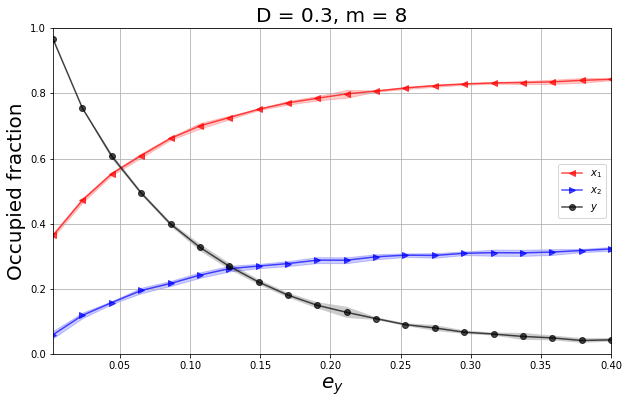

In [176]:
fig = plt.figure(figsize=(10,6))
mx1 = np.array([np.mean(x) for x in x1_ey])
sx1 = np.array([np.std(x) for x in x1_ey])
mx2 = np.array([np.mean(x) for x in x2_ey])
sx2 = np.array([np.std(x) for x in x2_ey])
my = np.array([np.mean(x) for x in y_ey])
sy = np.array([np.std(x) for x in y_ey])
plt.plot(eys, mx1 , '<-', label = r'$x_{1}$', color = 'red', alpha = .7)
plt.plot(eys, mx2, '>-',label = r'$x_{2}$', color = 'blue', alpha = .7)
plt.plot(eys, my, 'o-',label = r'$y$', color = 'black', alpha= .7)
plt.fill_between(eys, mx1-sx1, mx1+sx1, alpha = .2, color = 'red')
plt.fill_between(eys, mx2-sx2, mx2+sx2, alpha = .2, color = 'blue')
plt.fill_between(eys, my-sy, my+sy, alpha = .2, facecolor = 'black')
plt.xlabel(r'$e_{y}$', fontsize=20)
plt.ylabel('Occupied fraction', fontsize=20)
plt.title('D = ' + str(0.3) + ', m = ' + str(m), fontsize = 20)
plt.grid()
plt.legend(loc = 'best')
plt.xlim((min(eys),max(eys)))
plt.ylim((0,1))

filename = 'BarridoEy_BA_m' + str(m) + '_D' + str(D)
plt.savefig(filename + '.pdf')
ofile = open(filename + '_x1.txt', "w")
for row in x1_ey:
    for it in row:
      ofile.write(str(it) + ' ')
    ofile.write('\n')
ofile.close()
ofile = open(filename + '_x2.txt', "w")
for row in x2_ey:
    for it in row:
      ofile.write(str(it) + ' ')
    ofile.write('\n')
ofile.close()
ofile = open(filename + '_y.txt', "w")
for row in y_ey:
    for it in row:
      ofile.write(str(it) + ' ')
    ofile.write('\n')
ofile.close()

In [134]:
#Current device
device = T.device("cuda" if T.cuda.is_available() else "cpu")

#Global parameters
N = 10000 #If N too large (> 10000), use sparse_coo. Otw use sparse, as its much faster.
m = 4 #Barabasi-albert parameter
max_it = 1000 #Number of iterations in the simulation
n_ens = 1
sparce_coo = False

#Model parameters
cx1 = .05
cx2 = .1
ex1 = .05
ex2 = .05
mux1 = .3
mux2 = .8
cy = .015
ey = .1
params = np.array([cx1, cx2, ex1, ex2, mux1, mux2, cy, ey])
mus = np.linspace(0.01, 1, 20)

#Forbidden nodes
random_desconection = False
D = .0 #If random selection desired
Nd = int(D*N) #First Nd nodes (of max degree) to be deleted

world = network(N, device, 'barabassi', m)
world.remove_nodes(D = D, Nd = Nd, random_removal = random_desconection)
N = world.N
x1, x2, y = world.initial_occupancy(.5,.5,.5)
world.set_species_params(params)

if sparce_coo:
    #List of neigbhors -> sparce_coo tensor.
    world.sparse_coo_matrix()
else:
    #G -> numpy array of adjacency matrix -> sparse tensor of A.
    world.sparse_matrix()
###
x1_mus = []
x2_mus = []
y_mus  = []
for mu1 in mus:
  world.mux1 = mu1 #Update mux1 parameter
  print('mu1: ' + str(mu1))
  aux_x1_2, aux_x2_2, aux_y_2 = [], [], []
  for mu2 in mus:
    world.mux2 = mu2 #update mux2 parameter
    #for i in range(n_ens):
    for _ in range(max_it):
        x1, x2, y = world.update()
    aux_x1_2.append(T.sum(x1).view(1,-1).detach().cpu().numpy()[0][0]/N)
    aux_x2_2.append(T.sum(x2).view(1,-1).detach().cpu().numpy()[0][0]/N)
    aux_y_2.append(T.sum(y).view(1,-1).detach().cpu().numpy()[0][0]/N)  
    world.reset() #Resets dynamics and creates new network.
  x1_mus.append(aux_x1_2)
  x2_mus.append(aux_x2_2)
  y_mus.append(aux_y_2)

mu1: 0.01
mu1: 0.06210526315789474
mu1: 0.11421052631578947
mu1: 0.16631578947368422
mu1: 0.21842105263157896
mu1: 0.2705263157894737
mu1: 0.32263157894736844
mu1: 0.37473684210526315
mu1: 0.4268421052631579
mu1: 0.4789473684210527
mu1: 0.5310526315789474
mu1: 0.5831578947368421
mu1: 0.6352631578947369
mu1: 0.6873684210526316
mu1: 0.7394736842105263
mu1: 0.791578947368421
mu1: 0.8436842105263158
mu1: 0.8957894736842106
mu1: 0.9478947368421053
mu1: 1.0


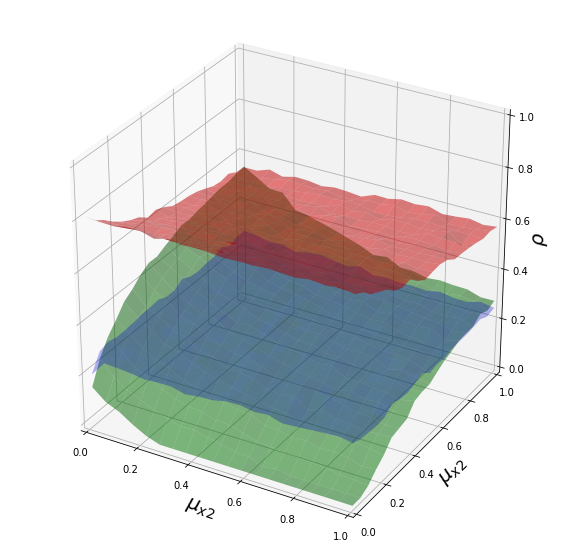

In [136]:
X, Y = np.meshgrid(mus, mus)
# Plot the surface.
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X, Y, np.array(x1_mus), alpha = .5, color = 'red')
surf = ax.plot_surface(X, Y, np.array(x2_mus), alpha = .5, color = 'green')
surf = ax.plot_surface(X, Y, np.array(y_mus), alpha = .3, color = 'blue', label = 'y')
ax.set_xlabel(r'$\mu_{x2}$', fontsize = 20)
ax.set_ylabel(r'$\mu_{x2}$',fontsize = 20)
ax.set_zlabel(r'$\rho$',fontsize = 20)
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_zlim((0,1))
plt.savefig('Var_mus_conf3.pdf')